# Autograd: automatic differentiation

The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

In [1]:
import torch

Create a tensor:

In [21]:
# Create a 2x2 tensor with gradient-accumulation capabilities
# requires_grad_(True)를 실행하면 그 텐서에 행해지는 모든 연산에 대한 미분값을 계산함.
x = torch.tensor([[1, 2], [3, 4]], requires_grad=True, dtype=torch.float32)
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


Do an operation on the tensor:

In [22]:
# Deduct 2 from all elements
y = x - 2
print(y)

tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<SubBackward0>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.



In [28]:
# `grad_fn` : 이는 Tensor 를 생성한 Function 을 참조하고 있습니다. 
# (단, 사용자가 만든 Tensor는 예외로, 이 때 grad_fn 은 None 입니다.)
# requires_grad=False(default)일 때는 None이 나옴
print(y.grad_fn)

In [24]:
# What's happening here?
print(x.grad_fn)

None


In [25]:
# Let's dig further...
y.grad_fn

In [26]:
# requires_grad=False(default)일 때는 오류 (grad를 저장하지 않았으니까 추적 불가능한 듯.)
y.grad_fn.next_functions[0][0]

In [27]:
y.grad_fn.next_functions[0][0].variable

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

In [30]:
# Do more operations on y
z = y * y * 3 # Mul
a = z.mean()  # average

print(z)
print(a)

tensor([[ 3.,  0.],
        [ 3., 12.]], grad_fn=<MulBackward0>)
tensor(4.5000, grad_fn=<MeanBackward0>)


In [31]:
# Let's visualise the computational graph! (thks @szagoruyko)
from torchviz import make_dot

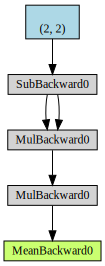

In [32]:
make_dot(a)

## Gradients

Let's backprop now `out.backward()` is equivalent to doing `out.backward(torch.tensor([1.0]))`

In [33]:
# Backprop : compute gradients
a.backward()

Print gradients $\frac{\text{d}a}{\text{d}x}$.




In [34]:
# Compute it by hand BEFORE executing this
print(x.grad)

tensor([[-1.5000,  0.0000],
        [ 1.5000,  3.0000]])


You can do many crazy things with autograd!
> With Great *Flexibility* Comes Great Responsibility

In [37]:
# Dynamic graphs!
x = torch.randn(3, requires_grad=True)

y = x * 2
i = 0
while y.data.norm() < 1000:
    y = y * 2
    i += 1
print(y)

tensor([-4.6412e-01, -1.6008e+03, -1.1095e+03], grad_fn=<MulBackward0>)


In [36]:
# Dynamic graphs!
x = torch.randn(3, requires_grad=False)

y = x * 2
i = 0
while y.data.norm() < 1000:
    y = y * 2
    i += 1
print(y)

tensor([ 331.3463, -627.5721,  813.8320])


In [39]:
# If we don't run backward on a scalar we need to specify the grad_output
gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
y.backward(gradients) # dy/dgradients

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


In [40]:
# BEFORE executing this, can you tell what would you expect it to print?
print(i)

9


## Inference

In [41]:
# This variable decides the tensor's range below
n = 3

In [42]:
# Both x and w that allows gradient accumulation
x = torch.arange(1., n + 1, requires_grad=True)
w = torch.ones(n, requires_grad=True)
z = w @ x
z.backward()
print(x.grad, w.grad, sep='\n')

tensor([1., 1., 1.])
tensor([1., 2., 3.])


In [43]:
# Only w that allows gradient accumulation
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)
z = w @ x
z.backward()
print(x.grad, w.grad, sep='\n')

None
tensor([1., 2., 3.])


In [44]:
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)

# Regardless of what you do in this context, all torch tensors will not have gradient accumulation
with torch.no_grad():
    z = w @ x

try:
    z.backward()  # PyTorch will throw an error here, since z has no grad accum.
except RuntimeError as e:
    print('RuntimeError!!! >:[')
    print(e)

RuntimeError!!! >:[
element 0 of tensors does not require grad and does not have a grad_fn


## More stuff

Documentation of the automatic differentiation package is at
http://pytorch.org/docs/autograd.